In [10]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import CubicSpline
import matplotlib.animation as animation
from pltFunctions import *

# Enable interactive plot
%matplotlib notebook

# El sistema.

El sistema consta de un objeto que se mueve de manera erratica en una superficie plana mientras que es observado por una cámara situada en posición perpendicular al plano, y a una distancia de 2 m. Por simplicidad podemos imaginarnos que el sistema es similar al que se muestra en la siguiente figura:

![Image](images/BallAndPlate-oct.png)

Nuestro interes es hacer un seguimiento del la bola mientras esta se mueve en el espacio *i.e.*, conocer donde se encuentrá en cada instante.


## Descripcion de generación de datos.

Por motivos didácticos, en lugar de trabajar con datos reales, vamos a generar datos artificiales para probar el algoritmo. 

La generación de los datos consta de dos etapas: 

 * Generación de una trayectoria acotada en el espacio.
 * Generar las mediciones proyectando dicha trayectoria a la cámara.
 * Anãdir ruido a las mediciones.

### Generacion de la trayectoria

Utilizamos las ecuaciones de Mackey-Glass para generar una señal con un comportamiento cáotico, y se extraen segmentos de ésta para codificar lo posición de la trayectoria en el espacio.

![Image](images/MG-hlf.png)![Image](images/TrayMG.png)

### Proyección de los datos

La trayectoria se proyecta a través de la siguiente relación:
$$
\mathbf{x}
\begin{aligned}
    x &= \frac{fX}{Z}+x_o\\
    y &= \frac{fY}{Z}+y_o\\
\end{aligned}
$$ donde $(x,y)$ son las coordenadas en el plano de la imagen, $(X, Y, Z)$ son las coordenadas de la trayectoria generada $X$ y $Y$ se obtienen de la serie de tiempo y $Z=2$. los parámetros intrinsecos de la cámara están definidos por $f$, $(x_o, y_o)$ que representan la distancia focal y el punto principal de la cámara.

### Añadir Ruido.

La secuencia de datos generada, se le añade ruido bajo una distribución Gaussiana, con media 0 y cuya varianza se define para componente de manera independiente.



In [11]:
# Cargamos un archivo que contiene un trayectoria.
datTray = np.load ("curveMG2.npz")

# Extraemos la información importante.
Crv = datTray['Crv'] # Curva y sys derivadas en coordenadas espaciales.
iCrv = datTray['iCrv'] # Curva proyectada y sus coordenadas espaciales en la imagen.
K  = datTray['K'] # Matriz de calibración de la cámara.
Z  = datTray['Z'] # Distancia entre la cámara y la superficie donde se mueve el obj.
 
_, N = Crv.shape #Obtenemos el número de muestras con el que contamos.

# Extraemos de la matriz K los parámetros intrinsecos de la cámara.
f = K[0,0]  # distancia focal (en pix./m.)
# Las coordenadas del punto principal de la imagen.
xo = K[0,2]
yo = K[1,2]

# El intervalo de tiempo entre muestras.
dt = 0.1

#Le añadimos ruido a las mediciones de la trayectoria y generamos los datos de medición.
#definimos en ruido de medicion.
varPosX = 02.5
varPosY = 02.5
varVelX = 1.5 * 10e-4
varVelY = 1.5 * 10e-4

N -= 1

factNR = 1.

# Definimos el ruido de medición que vamos a añadir a los datos.
noiseX  = rnd.normal(0, np.sqrt(varPosX), (1, N))
noiseY  = rnd.normal(0, np.sqrt(varPosY), (1, N))
noiseVX = rnd.normal(0, np.sqrt(varVelX), (1, N))
noiseVY = rnd.normal(0, np.sqrt(varVelY), (1, N))

# Definimos el valor real de la trayectora del objeto, y su derivada.
z = np.vstack([iCrv[:2,:N],np.diff(iCrv[:2,:])/dt])

# Definimos la señal con la que vamos a trabajar: redondeando z y añadiendole error.
zn = np.round(np.round(z) + factNR * np.vstack([noiseX, noiseY, noiseVX, noiseVY]), 1)

## El estado del sistema.

El sistema es caracterizado por un estado $\mathbf{x}$, que contiene información de la posición y velocidad del objeto en el plano.

$$
\begin{aligned}
    \mathbf{x} &= \left[X, Y, \dot{X}, \dot{Y} \right]^\top
\end{aligned}
$$

donde $\mathbf{x}$ es el estado, $(X, Y)$  y $(\dot{X}, \dot{Y})$ son las coordenadas  y la velocidad del objeto en el plano.

## Mediciones.

Es a través de la cámara que sensamos la posición y velocidad del objeto en el espacio.

Las mediciones las realizamos a través de la cámara se agrupan en el vector de medición $\mathbf{z}$ que definimos como sigue:

$$
\begin{aligned}
    \mathbf{z} &= \left[ x, y, \dot{x}, \dot{y} \right]^\top
\end{aligned}
$$

El modelo que describe la relación entre las cantidades observadas en la cámara y aquellas que forman el estado del sistema se define como sigue:

$$
\begin{aligned}
    \mathbf{z} &= \mathbf{H}\mathbf{x}
\end{aligned}
$$

En este caso particular, la relación entre el estado y las mediciones están dadas por las siguientes ecuaciones:

$$
\begin{aligned}
    x &= \frac{fX}{Z}+x_o\\
    y &= \frac{fY}{Z}+y_o\\
    \dot{x} &= f\frac{\dot{X}+x\dot{Z}}{Z}\\
    \dot{y} &= f\frac{\dot{Y}+y\dot{Z}}{Z}
\end{aligned}
$$

Simplificamos la expresión anterior para utilizar coordenadas canonicas haciendo los siguientes cambios de variable $y_c=\frac{x-x_0}{f}$, $y_c=\frac{y-y_0}{f}$ y tomando en cuenta que $Z$ es constante, obtenemos lo siguiente:

$$
\begin{aligned}
    x_c &= \frac{X}{Z}\\
    y_c &= \frac{Y}{Z}\\
    \dot{x_c} &= \frac{\dot{X}}{Z}\\
    \dot{y_c} &= \frac{\dot{Y}}{Z}
\end{aligned}
$$


# Etapa de predicción:


La ecuación de transición de estado establece la relación entre el estado previo del sistema, y el estado actual, considerando señales de control.

$$
\begin{aligned}
    \mathbf{x}_k &= \mathbf{A}\mathbf{x}_{k-1}+\mathbf{BU}
\end{aligned}
$$
donde el vector $\mathbf{x}_k$ es el estado en el tiempo $k$, $\mathbf{A}$ es la matriz de transición de estado del sistema y la matriz $\mathbf{B}$ relacióna la entrada de control $\mathbf{U}_k$, que es un parámetro opcional.


En este ejemplo no hay una entrada de control y la relación entre estados se define a través de las ecuaciónes de movimiento de Newton:

$$
\begin{aligned}
    x &= x_o + \dot{x}\Delta t + \frac{1}{2}\ddot{x}{\Delta t}^2
\end{aligned}
$$

A partir de esta ecuación podemos definir la matriz $\mathbf{A}$ como sigue:

$$
\begin{aligned}
\mathbf{A} &= \left[
    \begin{array}{cccc}
    1 & 0 & \Delta t & 0\\
    0 & 1 & 0 & \Delta t\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & 1\\
    \end{array}
    \right]
\end{aligned}
$$

## La matriz de covarianza de proceso.

La matriz de covarianza del proceso la podemos definir de la siguiente manera.

Supongamos que tenemos una matriz de covarianza que corresponde únicamente a errorres en velocidad. 

$$
\begin{aligned}
    \mathbf{Q}_v &= 
    \left[\begin{array}{cccc}
      0 & 0 & 0 & 0 \\
      0 & 0 & 0 & 0 \\
      0 & 0 & 1 & 0 \\
      0 & 0 & 0 & 1 \\
    \end{array}\right]\sigma^2_v
\end{aligned}
$$ donde $\sigma^2_b$ corresponde a la varianza de la velocidad. Para entender como esta varianza se propaga al estado, podemos proyectar $\mathbf{Q}_v$ al espacio de estado completo utilizando la matriz de transición de estado:

$$
\begin{aligned}
    \mathbf{Q} & = \mathbf{A} \mathbf{Q}_v \mathbf{A}^\top\\
    & = 
    \left[\begin{array}{cccc}
      \Delta t^2 & 0 & \Delta t & 0 \\
      0 & \Delta t^2 & 0 & \Delta t \\
      \Delta t & 0 & 1 & 0 \\
      0 & \Delta t & 0 & 1 \\
    \end{array}\right]\sigma^2_v
\end{aligned}
$$ 


In [12]:
# Aqui definiremos las estructuras necesarias para almacenar el estado (x),
# su matriz de covarianza (P), la matriz de transición de estado (A),
# la matriz que caracteriza la incertidumbre el proceso (Q) y una función que no ayudará
# a canonizar los datos medidos.

# Como nos interesa almacenar como varía el estado, usaremos una matriz para representar el estado
# de tal manera que cada columna corresponda a un paso del algoritmo

# Aquí almacenaremos el estado estimado del sistema.
x = np.zeros((4, N))

# Aqui declaramos la variable donde almacenaremos el estado predicho del sistema
xp = np.zeros((4, N))

# Definimos las variables que almacenará la matrice de covarianza del estado
# Tanto la matriz de covarianza predicha que se calcula en la etapa de predicción
Pp = np.eye(4)


A=np.eye(4) #Matriz indentidad 4x4
A[0,2] = A[1,3] = dt

# La matriz de covarianza asociada al estado la definimos como sigue:
# Asumimos que las mediciones son independientes, y que el ruido asociado es alto.
P = np.eye(4)


#Definimos la matriz de covarianza del proceso (Q)
sigmaV = 0.05 #Este la varianza del ruido en la velocidad estimada.
Q = sigmaV * np.array([[dt**2, 0, dt, 0],[0, dt**2, 0, dt],[dt, 0, 1, 0],[0, dt, 0, 1]])

# definimos una función que canoniza los valores medidos en la imagen
# (hace un cambio de unidades de pixeles a metros.)
def canoniza(z, f, xo, yo):
    invF = 1. / f
    zx = invF * (z[0]-xo)
    zy = invF * (z[1]-yo)
    zvx = invF * z[2]
    zvy = invF * z[3]
    return np.array([zx, zy, zvx, zvy])


# La Matriz de Medición

De acuerdo a la ecuación descrita antes en términos de las coordenadas canonicas, la matriz $\mathbf{H}$ queda definida como sigue:
$$
\begin{aligned}
    \mathbf{H} &= \left[
    \begin{array}{cccc}
     \frac{1}{Z} & 0 & 0 & 0\\
     0 & \frac{1}{Z} & 0 & 0\\
     0 & 0 & \frac{1}{Z}& 0\\
     0 & 0 & 0 & \frac{1}{Z}
    \end{array}
    \right]
\end{aligned}
$$

El ruido asociado a la medición se representa como la matriz de covarianza $\mathbf{R}$.
Idealmente, esta matriz se construye a partir de conocimiento de primera mano de los sensores que se utilizan para obtener datos, o del proceso que genero los datos.

En este caso vamos a definirlo en terminos de la varianzas usadas para generar la trayectoria artificial que definimos en éste ejemplo:
$$
\begin{aligned}
    \mathbf{R} &= \left[
    \begin{array}{cccc}
    \sigma^2_x & 0 & 0 & 0\\
     0 & \sigma^2_y & 0 & 0\\
     0 & 0 & \sigma^2_\dot{x}& 0\\
     0 & 0 & 0 & \sigma^2_\dot{y}
    \end{array}
    \right]
\end{aligned}
$$

In [13]:
# Definimos la matriz de Medición
H = np.eye(4)/Z

# Definimos la matriz de covarianza del error de medición.
R = np.diag([varPosX, varPosY, varVelX, varVelY])

In [14]:
# Aqui vamos a almacenar la corrección de cada etapa.
crc = np.zeros(x.shape)

# Inicializamos el sistema.

k = 0

#Obtenemos la primera medición y la canonizamos:
zc = canoniza(zn[:,k], f, xo, yo)

# A partir de la primera medición inicializamos el estado
x[:,k] = [zc[0]*Z[0], zc[1]*Z[0], -zc[2]*Z[0], -zc[2]*Z[0]]


#Inicializamos la matriz de covarianza P
P = np.eye(4)


# Ciclo principal del algoritmo

En el siguiente bloque se muestra el ciclo principal del algoritmo.

![Image](images/FiltroKalman.png)


In [15]:
k = 1
while k < N:
    # Etapa de prediccción
    xp[:, k-1] = np.dot(A, x[:,k-1])
    Pp = np.dot(A, np.dot(P, A.T))+Q
    
    # Etapa de actualización
    
    # Obtenemos la primera medición y la canonizamos:
    zc = canoniza(zn[:,k], f, xo, yo)
    
    # Calculamos la ganancia de Kalman
    Kg = np.dot(np.dot(Pp,H.T), np.linalg.inv(np.dot(H,np.dot(Pp,H.T))+R))
    
    # Almacenamos el vector de corrección.
    crc[:,k-1] = np.dot(Kg,zc - np.dot(H,xp[:, k-1]))
    
    # Actualizamos el estado estimado
    x[:, k] = xp[:, k-1] + np.dot(Kg,zc -np.dot(H,xp[:, k-1]))
    
    # Actualizamos la matriz de covarianza del estado
    P = np.dot((np.eye(4) - np.dot(Kg, H)), Pp)
    
    # Incrementamos k
    k += 1

# Gráfica de resultados. 

En este bloque presentamos dos gráficas:

 * Primero, la grafica de las mediciónes proyectadas en el espacio del estado vs el estado estimado.
 * Segundo, la grafica de el estado real vs el estado estimado.

<IPython.core.display.Javascript object>


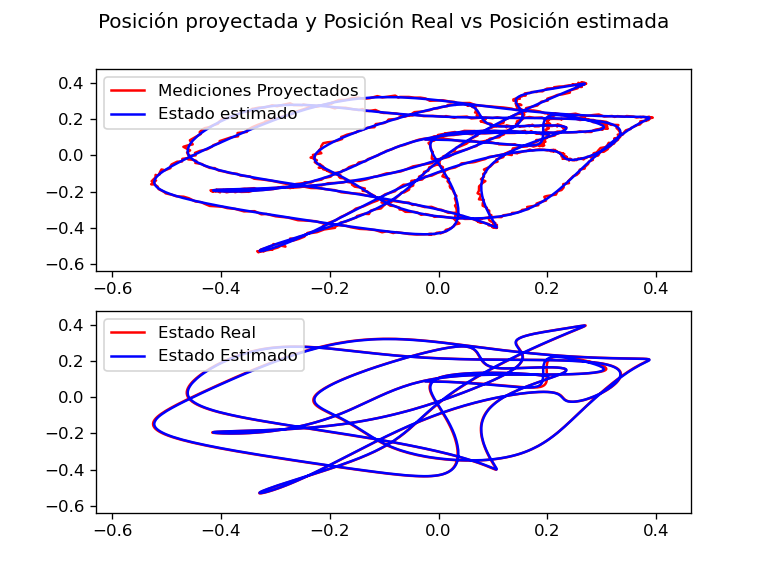

In [16]:
#Calculamos lo valores máximos y mínimos de la trayectoria.
pCxMin, pCxMax = np.min(Crv[0,:]), np.max(Crv[0,:])
pCyMin, pCyMax = np.min(Crv[1,:]), np.max(Crv[1,:])

pCvxMin, pCvxMax = np.min(Crv[2,:]), np.max(Crv[2,:])
pCvyMin, pCvyMax = np.min(Crv[3,:]), np.max(Crv[3,:])

pXxMin, pXxMax = np.min(x[0,:]), np.max(x[0,:])
pXyMin, pXyMax = np.min(x[1,:]), np.max(x[1,:])

pXvxMin, pXvxMax = np.min(x[2,:]), np.max(x[2,:])
pXvyMin, pXvyMax = np.min(x[3,:]), np.max(x[3,:])

iCrv = np.dot(np.linalg.inv(H), (zn[:4,:]-np.array([[xo],[yo],[0],[0]]))/f)

fig0, (ax00, ax01) = plt.subplots(2,1)
fig0.suptitle("Posición proyectada y Posición Real vs Posición estimada")
ax00.set_xlim(1.2 * pCxMin, 1.2 * pCxMax)
ax00.set_ylim(1.2 * pCyMin, 1.2 * pCyMax)
ax00.plot(iCrv[0,:N],iCrv[1,:N],'r', label='Mediciones Proyectados')
ax00.plot(x[0,:N], x[1,:N],'b',label='Estado estimado')
ax00.legend()

ax01.set_xlim(1.2 * pCxMin, 1.2 * pCxMax)
ax01.set_ylim(1.2 * pCyMin, 1.2 * pCyMax)
ax01.plot(Crv[0,:N], Crv[1,:N], 'r', label='Estado Real')
ax01.plot(x[0,:N], x[1,:N], 'b', label='Estado Estimado')
ax01.legend()


<IPython.core.display.Javascript object>


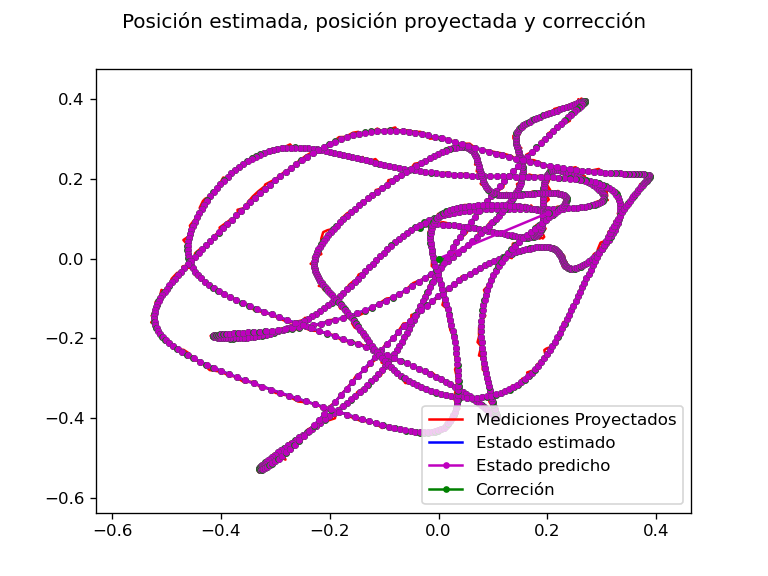

In [17]:
fig1, ax11 = plt.subplots(1,1)
fig1.suptitle("Posición estimada, posición proyectada y corrección")
ax11.set_xlim(1.2 * pCxMin, 1.2 * pCxMax)
ax11.set_ylim(1.2 * pCyMin, 1.2 * pCyMax)
ax11.plot(iCrv[0,:N],iCrv[1,:N],'r', label='Mediciones Proyectados')
ax11.plot(x[0,:N], x[1,:N],'b', label='Estado estimado')

ax11.plot([x[0,0],xp[0,0]], [x[1,0],xp[1,0]],'.-m',label='Estado predicho' )
ax11.plot([xp[0,0],xp[0,0]+crc[0,0]], [xp[1,0],xp[1,0]+crc[1,0]],'.-g', label='Correción')
for i in range(1,N):
    ax11.plot([x[0,i],xp[0,i]], [x[1,i],xp[1,i]],'.-m')
    ax11.plot([xp[0,i],xp[0,i]+crc[0,i]], [xp[1,i],xp[1,i]+crc[1,i]],'.-g')
ax11.legend()

# Evolución del estado.

    En las siguientes dos gráficas se muestran animaciónes que ilustran la evolución del sistema conforme pasa el tiempo.
    
    La primera animación muestra  la traza de los valores que toma el estado (en azul) así como la proyección de los datos en el estado, (en rojo).
    
    La segunda animación muestra un acercamiento al frente de la traza, graficando en rojo la proyección de los datos en el estado, en azul el estado estimado y en cyan el valor real.

<IPython.core.display.Javascript object>


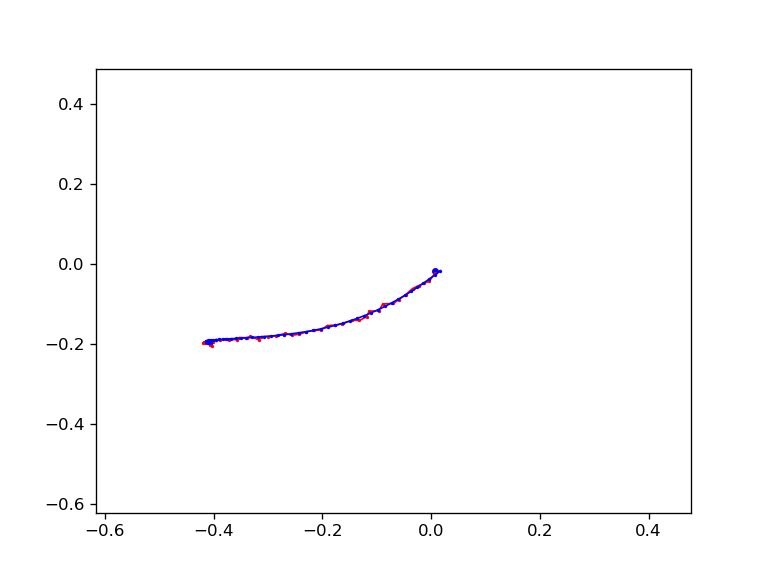

In [18]:
tracePlotA = dispTrace(tr=True, trLn=50)

tracePlotA.setPoints(['r.','b.'])
tracePlotA.setTraces(['r.-','b.-'])
tracePlotA.setLimits(pCxMin, pCxMax,pCyMin, pCyMax)

def update_pointA(itr, coors, trPlt):
     
    if itr == 0:
        for q in trPlt.queues:
            q.clear()
        return
    j = 0
    for i in range(trPlt.nTraces):
        trPlt.queues[j].append(coors[i][0, itr])
        trPlt.queues[j+1].append(coors[i][1, itr-1])
        j += 2
    
    trPlt.points[0].set_data(coors[0][:2, itr])
    trPlt.points[1].set_data(coors[1][:2, itr-1])
    trPlt.traces[0].set_data(trPlt.queues[0], trPlt.queues[1])
    trPlt.traces[1].set_data(trPlt.queues[2], trPlt.queues[3])

aniA= animation.FuncAnimation(tracePlotA.fig, update_pointA, N, fargs=([iCrv,x], tracePlotA), interval=50)
plt.show()

<IPython.core.display.Javascript object>


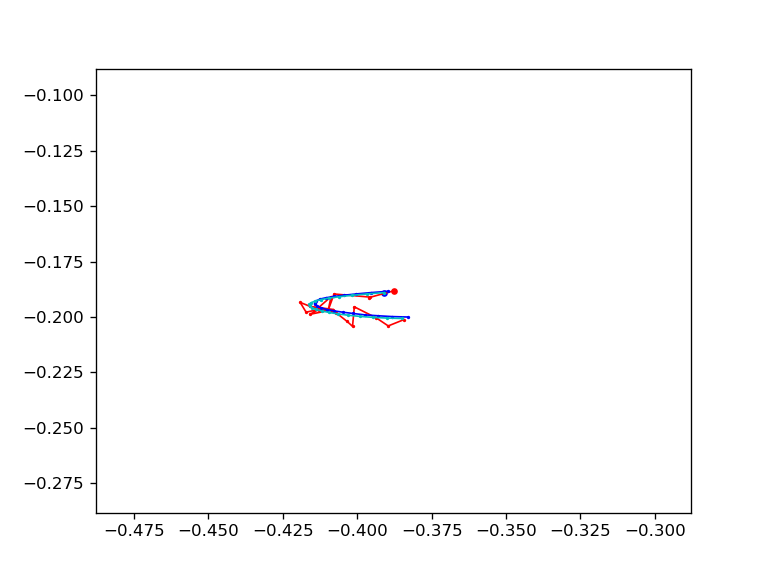

In [19]:
tracePlotB = dispTrace(tr=True, trLn=20)

tracePlotB.setPoints(['r.','b.','m.'])
tracePlotB.setTraces(['r.-','b.-','c.-'])
tracePlotB.setLimits(pCxMin, pCxMax,pCyMin, pCyMax)

def update_pointB(itr, coors, trPlt):
     
    if itr == 0:
        for q in trPlt.queues:
            q.clear()
        return      
        
    trPlt.queues[0].append(coors[0][0, itr])
    trPlt.queues[1].append(coors[0][1, itr])
    trPlt.queues[2].append(coors[1][0, itr-1])
    trPlt.queues[3].append(coors[1][1, itr-1])
    trPlt.queues[4].append(coors[2][0, itr])
    trPlt.queues[5].append(coors[2][1, itr])
    
    Xc, Yc = coors[0][0, itr], coors[0][1, itr]
    trPlt.ax.set_xlim(Xc-0.1, Xc+0.1)
    trPlt.ax.set_ylim(Yc-0.1, Yc+0.1)
    
    trPlt.points[0].set_data(coors[0][:2, itr])
    trPlt.points[1].set_data(coors[1][:2, itr-1])
    trPlt.points[1].set_data(coors[2][:2, itr])
    trPlt.traces[0].set_data(trPlt.queues[0], trPlt.queues[1])
    trPlt.traces[1].set_data(trPlt.queues[2], trPlt.queues[3])
    trPlt.traces[2].set_data(trPlt.queues[4], trPlt.queues[5])

aniB = animation.FuncAnimation(tracePlotB.fig, update_pointB, N, fargs=([iCrv,x,Crv], tracePlotB), interval=50)
plt.show()